![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

import pandas as pnd
from scipy.cluster.hierarchy import dendrogram, linkage

# Classification ascendante hiérarchique

## Mise en situation
Je travaille sur un regroupement de données en classification, un peu comme les k-means, mais je souhaite des classes un peu plus structurées : un peu comme le reigne animal qui se décompose en sous-classes, avec des vertébrés et des invertébrés, et parmis les vertébrés les animaux terrestres et les animaux marins, etc...

Bref, je veux catégoriser une hiérarchie.

## La CAH (classification ascendante hiérarchique)
### Définition formelle
J'ai un ensemble de données avec certaines mesures chiffrées, et je souhaite leur assigner **des** classes (et non pas une seule):
* Toutes les données font partie de la "super-classe principale" par exemple
* Toutes les données font partie d'une classe qui leur est propre et dans laquelle elles sont seules

C'est le principe d'un arbre, à un détail près qu'on va ajouter tout de suite :
* Etre dans deux classes signifie obligatoirement que l'une des deux est totalement incluse dans l'autre

Autrement dit, je ne peux pas avoir plusieurs chemins de la racine vers une donnée "finale".

### Le principe

La CAH est intuitivement très simple à comprendre:
* Toutes les données sont dans des classes isolées.
* Tant que toutes les données ne sont pas regroupées en une seule classe : 
  * On cherche les deux classes parmis les classes de plus haut niveau qui minimisent la _dissemblance_ entre elles
  * On regroupe ces deux classes en une nouvelle - les deux anciennes ne sont plus des classes de plus haut niveau

On peut introduire une variante : au lieu de boucler jusqu'à avoir une seule classe, on peut boucler jusqu'à en avoir $n > 1$ (si je sais que je vais avoir $n$ classes intrinsèquement différentes), quitte même à les regrouper ensuite sous une classe chapeau - ou pas, c'est au choix !

### La dissemblance
Pour faire simple, la dissemblance entre deux données est la norme L2, ou distance euclidienne, puisque chaque donnée est un vecteur.

La dissemblance de deux classes... c'est plus tricky:
* on peut considérer que deux classes se ressemblent à partir de la distance entre leurs individus les plus dissemblants
* inversement, on peut considérer qu'il faille regarder les individus les moins dissemblants
* ou faire une moyenne
* ou autre chose ...

Il y a là un point d'attention particulier pour l'implémentation : si on ne fait pas gaffe, on va calculer des milliers de normes, et pour rien : elles ne changent pas d'une étape à l'autre, sauf pour les deux classes regroupées vis-à-vis de toutes les autres !

Pour partir sur une implémentation plus simple et quand même efficace, on partira sur une dissemblance 
> $d(c_1, c_2) = min(||x-y||, x \in c_1, y \in c_2)$

L'avantage est alors que si $c_3$ est l'union de $c_1$ et $c_2$, alors pour toute autre classe $c_j$ :
> $d(c_3, c_j) = min(d(c_1, c_j), d(c_2, c_j))$

_Et avec un max on pourrait bien entendu adapter_

### Un algorithme non-supervisé
Comme pour les K-means, je me contente de laisser le système trouver une classification en minimisant comme il le peut le _coût_ de la jointure entre deux classes

### Classification _descendante_ hiérarchique
Si on précise qu'il y a une classification **ascendante**, c'est probablement qu'il y en a une **descendante**. Et c'est le cas.

Au lieu de partir des parties pour remonter jusqu'au tout en jointant les plus proches classes, on peut à l'inverse partir du tout et le diviser en parties en coupant au plus éloigné.

Version "quick & dirty" pour bien comprendre : je fais un k-means avec k=2 sur l'ensemble, pour avoir deux blocs. Et je recommence sur chacun, récursivement, jusqu'à avoir des singletons.

## Simulation rapide
Validons rapidement le concept avec quelques exemples simples.

In [2]:
def cah(x, class_count = 1):
    m = x.shape[0]
    
    # Initialisation de toutes les distances (infinity pour des distances d'une classe avec elle-même)
    distances = np.zeros((m,m))
    classes = np.zeros((m,1))
    for i in range(m):
        for j in range(m):
            if i == j: distances[i][j] = np.infty
            else: distances[i][j] = np.sum((x[i,:]-x[j,:])**2)
        # chaque élément appartient à sa propre classe au début
        classes[i] = i
                
    while m > class_count:
        # On cherche la plus petite distance entre classes
        c1, c2 = np.unravel_index(distances.argmin(), distances.shape)
        # On met à jour la classe c2 qui se retrouve avalée dans c1
        classes[classes == c2] = c1

        # On met à jour les distances : dist(ck, c1) devient le minimum entre dist(ck,c1) et dist(ck,c2)
        # et par convention, dist(c2,...) vaut infinity pour ne plus se servir de cette classe
        distances[c1,:] = np.min([distances[c1,:], distances[c2,:]], axis = 0)
        distances[:,c1] = distances[c1,:].T
        distances[c2,:] = np.infty
        distances[:,c2] = np.infty
        distances[c1,c1] = np.infty
        m -= 1
    return classes


On va faire des petits tas de points un peu aléatoirement, et on va demander une classification par petits tas.

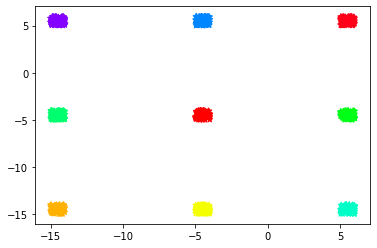

In [3]:
np.random.seed(1)
samples = 1000

data = np.random.rand(samples, 2)
split = np.random.randint(0, 3, (samples, 2)) * 10 - 15
data += split

plot.scatter(data[:,0], data[:,1], marker="*", c=cah(data, 9), cmap=plot.cm.hsv)
plot.show()

Cette implémentation n'est clairement pas la meilleure qui soit, et on perd la notion de hiérarchie, mais enfin on valide bien l'idée : chaque paquet est devenu un petit tas de couleur, comme attendu.

La visualisation de la hiérarchie est un peu plus compliquée : il faut pour celà utiliser des graphques de type _dendogramme_. Comme c'est pas simple à faire à la main, on va utiliser la librairie _scipy_.

Par contre, pour afficher un dendogramme, il faut la structure de découpage en hiérarchies, les distances relatives, etc... bref pas mal de choses à ajouter dans l'algo de CAH juste pour du rendu.

**Mais** comme cette librairie _scipy_ gère aussi la classification hiérarchique ascendante, pourquoi s'embêter à la re-coder ? :D

_Note: je sais que le principe du codeur confiné est aussi de faire découvrir des algorithmes et pas uniquement d'utiliser des librairies qui font tout et plus, sans suer la moindre goutte, mais dans ce cas précis la gestion de la hiérarchie dans la recherche (plutôt que des classes à plat) va beaucoup augmenter la quantité de code pour un algo si simple que ça serait dommage de polluer cet article. Accessoirement scipy propose des dissemblances pré-implémentées et on va le voir, celle qu'on a est loin d'être la meilleure !_

### Normalisation des données
Comme pour tous les algorithmes qui utilisent des distances, il peut être important de normaliser les données au besoin, et c'est le cas avec cet algorithme. Un  exemple en 2d (peu importe de quoi il s'agit):
* les données "5 dollars, 7000 mètres" et "5 dollars, 7040 mètres" sont assez proches pour un humain
* les données "5 dolars, 1000 mètres" et "44 dollars, 1000 mètres" paraissent plus éloignées

Mais pour une machine, c'est les seconds points qui paraissent plus proches : la distance n'est que de 39, qui est plus faible que 40...

## Retour à la mise en situation
### Chargement des données

En cherchant une mise en situation intéressante, je suis tombé sur un exemple un peu drôle et vraiment bien choisi sur la page de Marie Chavent, de l'université de Bordeaux (page [ici](http://www.math.u-bordeaux.fr/~mchave100p/teaching/)): une classification de fromages.

Le fichier présenté ici est un peu modifié, pour pouvoir se concentrer uniquement sur le seul sujet des CAH.

In [4]:
data = pnd.read_table("data/d14_data.txt",sep="\t",index_col=0,header=0)
data

,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium
Fromages,,,,,,,,,
CarredelEst,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20
Babybel,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27
Beaufort,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41
Bleu,342,336.0,211.1,28.9,37.1,27.5,20.2,90,27
Camembert,264,314.0,215.9,19.5,103.0,36.4,23.4,60,20
Cantal,367,256.0,264.0,28.8,48.8,5.7,23.0,90,30
Chabichou,344,192.0,87.2,27.9,90.1,36.3,19.5,80,36
Chaource,292,276.0,132.9,25.4,116.4,32.5,17.8,70,25
Cheddar,406,172.0,182.3,32.5,76.4,4.9,26.0,110,28


Permière étape, on normalise :

In [5]:
data_norm = (data - np.mean(data))/np.std(data)
data_norm

,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium
Fromages,,,,,,,,,
CarredelEst,-0.393814,1.305009,-1.729552,-0.197796,-0.725392,1.498935,-0.262805,-0.791769,-0.961510
Babybel,-0.393814,0.016290,0.224261,-0.527457,-0.236355,-0.508717,0.075208,-0.791769,-0.251534
Beaufort,1.535341,-1.389585,0.930596,1.725223,-0.592019,-0.945528,0.920240,2.119146,1.168417
Bleu,0.227064,1.109749,0.242774,0.516468,-1.311429,1.263729,-0.431812,0.372597,-0.251534
Camembert,-1.502523,0.864279,0.311129,-2.065872,1.352007,2.011348,0.244214,-1.373952,-0.961510
Cantal,0.781418,0.217130,0.996103,0.488996,-0.838558,-0.567519,0.159711,0.372597,0.052741
Chabichou,0.271412,-0.496966,-1.521639,0.241751,0.830637,2.002948,-0.579692,-0.209586,0.661292
Chaource,-0.881646,0.440284,-0.870843,-0.445042,1.893586,1.683739,-0.938831,-0.791769,-0.454384
Cheddar,1.646212,-0.720121,-0.167356,1.505449,0.276933,-0.634720,0.793485,1.536963,-0.150109


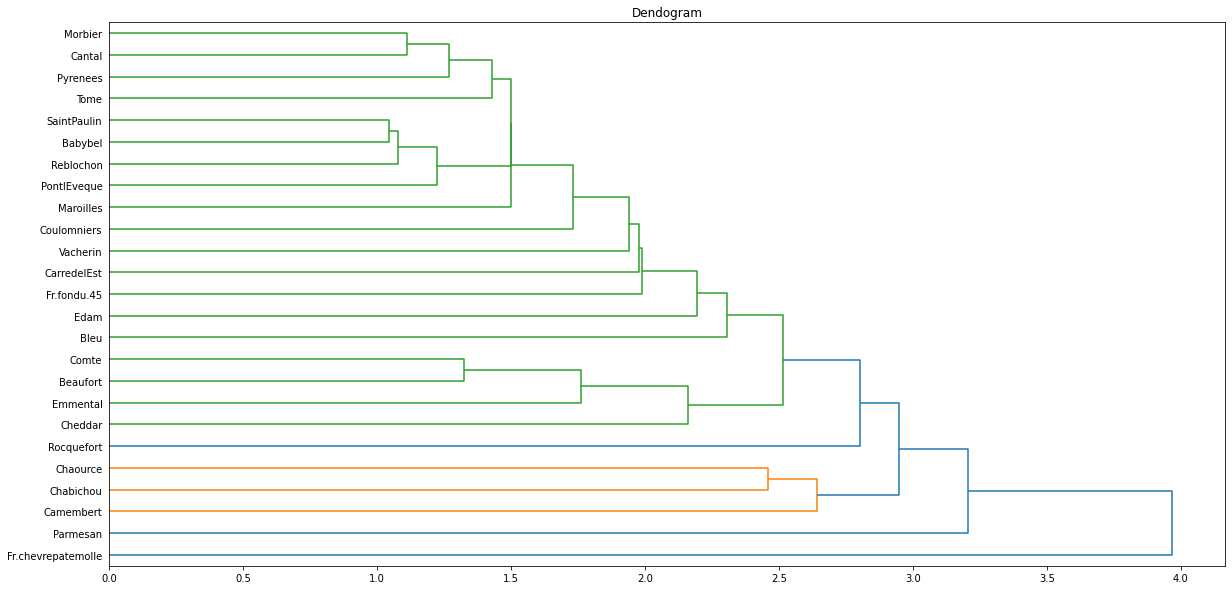

In [6]:
classification = linkage(data_norm,method='single',metric='euclidean')
plot.figure(figsize=(20,10))
plot.title("Dendogram")
dendrogram(classification,labels=data.index,orientation='right')
plot.show()

C'est à la fois bizarre, et pas très beau : c'est essentiellement lié à la dissemblance utilisée ('single' = le minimum, comme dans notre fonction). Avec des formules plus évoluées, comme la _méthode de Ward_, on obtient :

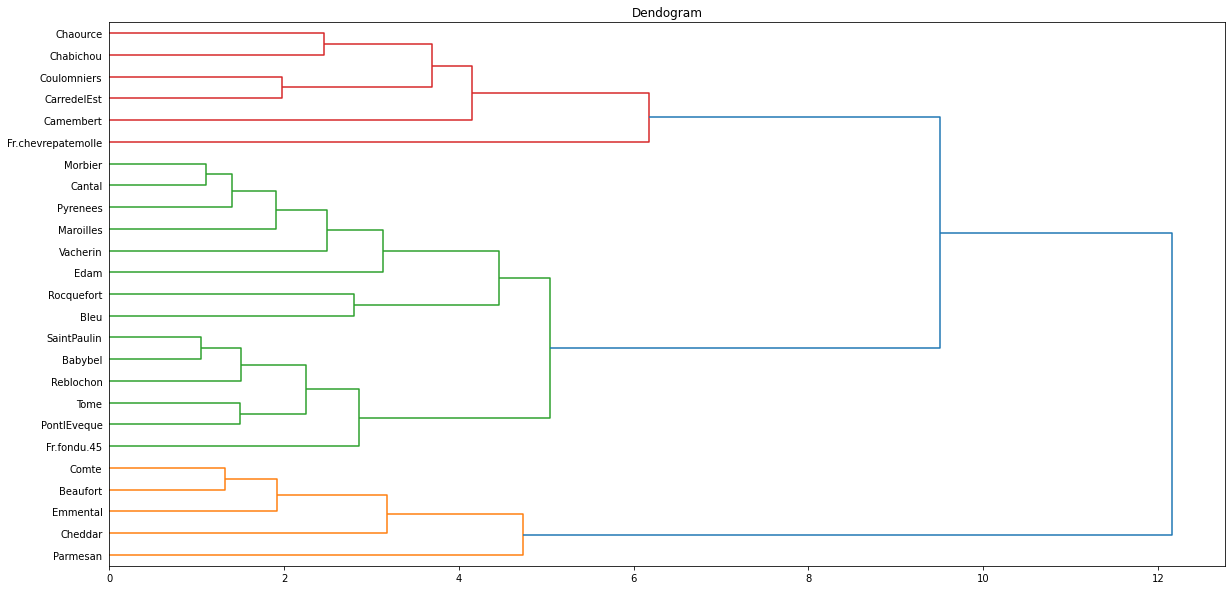

In [7]:
classification = linkage(data_norm,method='ward',metric='euclidean')
plot.figure(figsize=(20,10))
plot.title("Dendogram")
dendrogram(classification,labels=data.index,orientation='right')
plot.show()

C'est plus joli déjà. Et la librairie s'est permise de colorer quelques groupes, assez intéressants : chaque groupe correspond à des fromages un peu similaires.
* Le comté et le beaufort ou l'emmental par exemple sont en effet assez proches, comparés à du parmesan.
* Mais ils sont toujours plus proche du parmesan que d'un Camembert.

En version non-normalisée, on aurait eu ces différences:

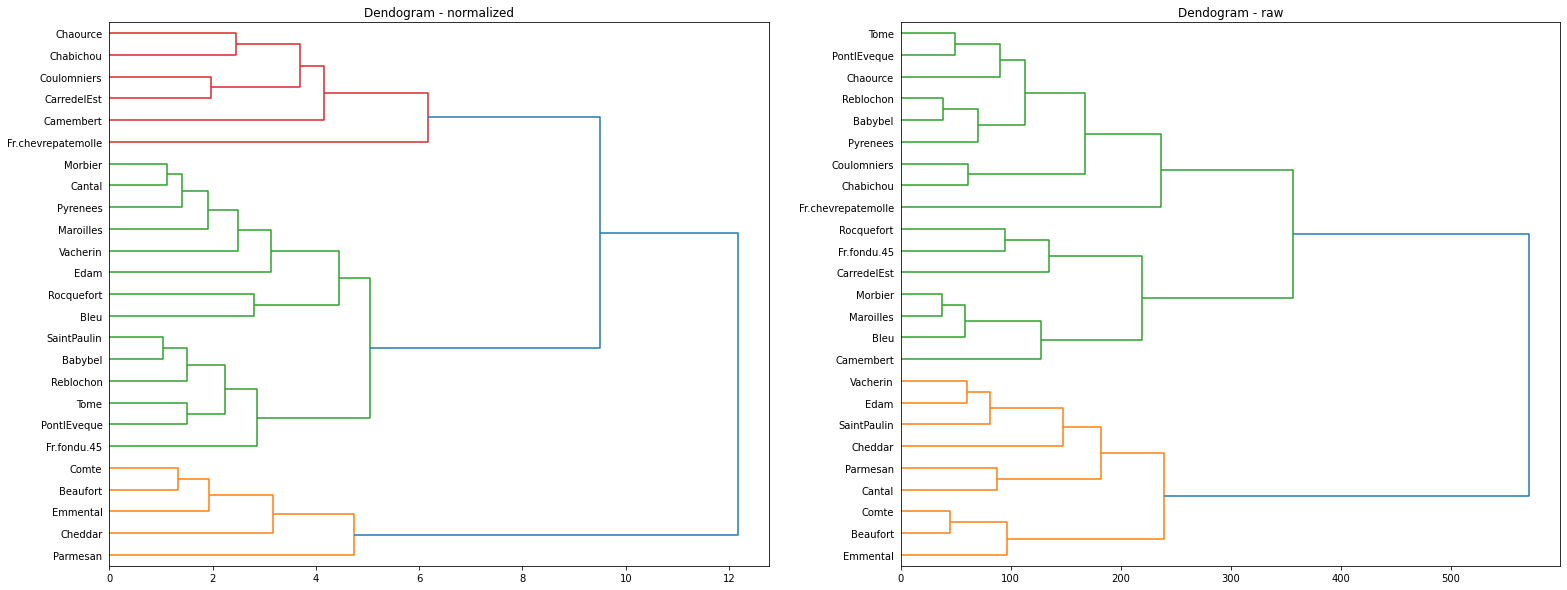

In [8]:
fig = plot.figure(figsize=(26,10))

fig.add_subplot(1,2,1)
classification = linkage(data_norm,method='ward',metric='euclidean')
plot.title("Dendogram - normalized")
dendrogram(classification,labels=data.index,orientation='right')

fig.add_subplot(1,2,2)
classification = linkage(data,method='ward',metric='euclidean')
plot.title("Dendogram - raw")
dendrogram(classification,labels=data.index,orientation='right')
plot.show()

C'est plus tout à fait la même chose. Les fromages vraiment proches (comme le comté et le beaufort) le sont toujours - on aurait pu ajouter l'abondance par exemple ça aurait été dans le même sac - mais enfin on voit aussi que le roquefort "non normalisé" est plus proche du fromage fondu alors que le roquefort normalisé est plus proche du bleu, ce qui parait intuitivement plus exact...